In [1]:
import numpy as np
from scipy.stats import scoreatpercentile
import pandas as pd
import seaborn as sns
from matplotlib import pylab as plt

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression

In [7]:
# dataset
# datset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
data = pd.concat([train,test])
data['LeadStatus'] = data['LeadStatus'].replace({"Passed":0, "Flagged":1, "Assign to CS":1})
data = data.drop(data[data['Country'] == 'ERROR'].index)
# data = data[data['VisitDay'] == 0]

X = data.values[:, 8:38]             # ALL data
X_colnames = data.columns[8:38]
y = data.values[:, 38]  # 'TOTAL PANSS'

ss_X = StandardScaler()
X = ss_X.fit_transform(X)
ss_y = StandardScaler()
y = ss_y.fit_transform(y.reshape(-1, 1))
y_bin = np.array(
    y >= scoreatpercentile(y, 50), dtype=np.int32)  # a classification problem !
y = np.squeeze(y_bin)

C: 0.0003 acc: 0.86
C: 0.0005 acc: 0.91
C: 0.0007 acc: 0.93
C: 0.0012 acc: 0.94
C: 0.0018 acc: 0.95
C: 0.0027 acc: 0.97
C: 0.0042 acc: 0.98
C: 0.0065 acc: 0.99
C: 0.0100 acc: 0.99
C: 0.0154 acc: 0.99
C: 0.0237 acc: 0.99
C: 0.0365 acc: 1.00
C: 0.0562 acc: 1.00
C: 0.0866 acc: 1.00
C: 0.1334 acc: 1.00
C: 0.2054 acc: 1.00
C: 0.3162 acc: 1.00
C: 0.4870 acc: 1.00
C: 0.7499 acc: 1.00
C: 1.1548 acc: 1.00
C: 1.7783 acc: 1.00
C: 2.7384 acc: 1.00
C: 4.2170 acc: 1.00
C: 6.4938 acc: 1.00
C: 10.0000 acc: 1.00


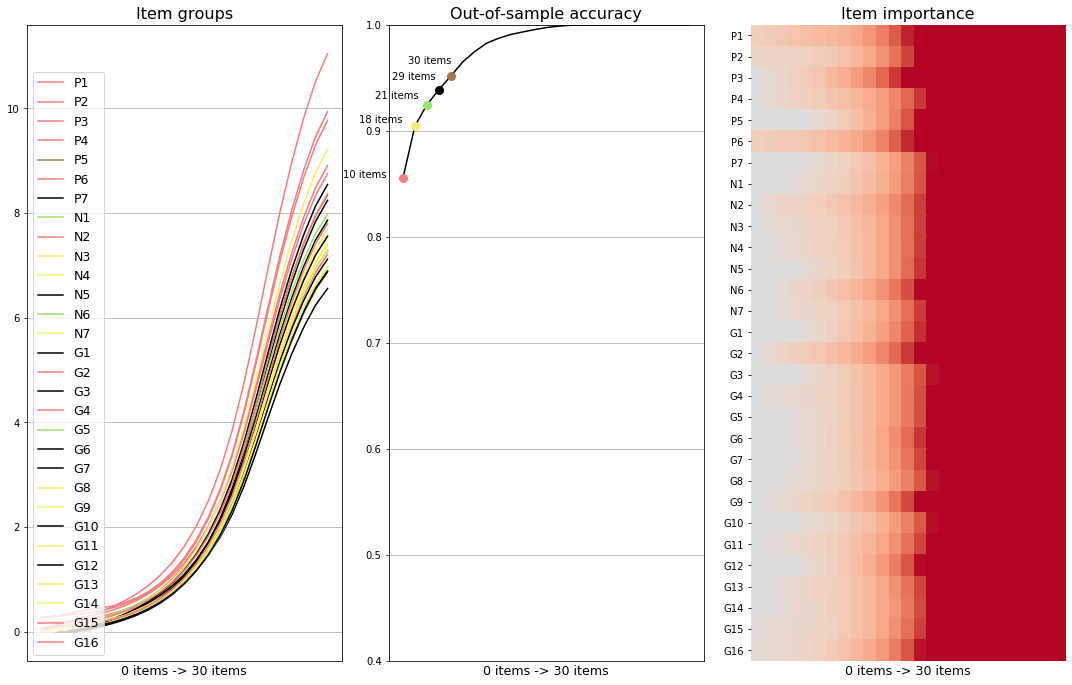

In [8]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


subplot_xlabel = '0 items -> 30 items'

# regularization paths´
# n_verticals = 16
n_verticals = 25
C_grid = np.logspace(-3.5, 1, n_verticals)
coef_list2 = []
acc_list2 = []
for i_step, my_C in enumerate(C_grid):
    sample_accs = []
    sample_coef = []
    for i_subsample in range(100):
        folder = StratifiedShuffleSplit(n_splits=100, test_size=0.1,random_state=i_subsample)
        train_inds, test_inds = next(iter(folder.split(X,y)))

        clf2 = LogisticRegression(penalty='l1', C=my_C, verbose=False)

        clf2.fit(X[train_inds, :], y[train_inds])
        pred_y = clf2.predict(X[test_inds, :])

        acc = (pred_y == y[test_inds]).mean()
        sample_accs.append(acc)
        
        sample_coef.append(clf2.coef_[0, :])

    coef_list2.append(np.mean(np.array(sample_coef), axis=0))
    acc_list2.append(np.mean(sample_accs))
    print ("C: %.4f acc: %.2f" % (my_C, acc))

coef_list2 = np.array(coef_list2)
acc_list2 = np.array(acc_list2)

# plot paths
n_cols = 3
n_rows = 1

my_palette = np.array([
    # '#4BBCF6',
    '#F47D7D', '#FBEF69', '#98E466', '#000000',
    '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030'
])
my_colors = np.array(['???????'] * coef_list2.shape[-1])
i_col = 0
new_grp_pts_x = []
new_grp_pts_y = []
new_grp_pts_col = []
new_grp_pts_total = []

for i_vertical, (params, acc, C) in enumerate(zip(
    coef_list2, acc_list2, C_grid)):
    b_notset = my_colors == '???????'
    b_nonzeros = params != 0
    b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)
    
    if np.sum(b_coefs_of_new_grp) > 0:
        # import pdb; pdb.set_trace()
        # we found a new subset that became 0
        for new_i in np.where(b_coefs_of_new_grp == True)[0]:
            # color all coefficients of the current group
            cur_col = my_palette[i_col]
            my_colors[new_i] = cur_col
            
        new_grp_pts_x.append(C)
        new_grp_pts_y.append(acc)
        new_grp_pts_col.append(cur_col)
        new_grp_pts_total.append(np.sum(b_nonzeros))
        i_col += 1


f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
    figsize=(15, 10), facecolor='white')
t, i_col = 0, 0

for i_line in range(X.shape[-1]):
    axarr[i_col].plot(np.log10(C_grid),
        coef_list2[:, i_line], label=X_colnames[i_line],
            color=my_colors[i_line], linewidth=1.5)

# axarr[0].set_xticks(np.arange(len(C_grid)))
# axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
axarr[i_col].set_xlabel(subplot_xlabel, fontsize=12.6)
axarr[i_col].legend(loc='lower left', fontsize=12.6)
axarr[0].grid(True)
# axarr[i_col].set_ylabel('Item groups', fontsize=16)
axarr[0].set_title('Item groups', fontsize=16)
axarr[0].set_xticks([])

# axarr[1].axis('off')
axarr[1].plot(np.log10(C_grid), acc_list2, color='#000000',
                 linewidth=1.5)
# axarr[1].set_title('ACCURACY')
axarr[1].set_ylim(0.4, 1.00)
axarr[1].grid(True)
# axarr[1].set_xticklabels(np.log10(C_grid), '')
axarr[1].set_xticks([])
axarr[1].set_xlabel(subplot_xlabel, fontsize=12.6)
# axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
axarr[1].set_title('Out-of-sample accuracy', fontsize=16)

for i_pt, (x, y, col, n_coefs) in enumerate(zip(
    new_grp_pts_x, new_grp_pts_y, new_grp_pts_col, new_grp_pts_total)):
    axarr[1].plot(np.log10(x), y,
                  marker='o', color=col, markersize=8.0)
    axarr[1].text(
        np.log10(x) - 0.95 + 0.07 * i_pt,
        y + 0.003 * i_pt,
        '%i items' % n_coefs)


sns.heatmap(coef_list2.T[::1], cbar=False, vmin=-1.5, vmax=1.5, cmap="coolwarm")

plt.yticks(np.arange(len(X_colnames)) + 0.5,
           X_colnames[::1], rotation=0)

axarr[2].set_title('Item importance', fontsize=16)
axarr[2].set_xlabel(subplot_xlabel, fontsize=12.6)
axarr[2].set_xticks([])

plt.tight_layout()
# plt.savefig('plots/regpath_extended.png', DPI=400, facecolor='white')
plt.show()